In [12]:
import lsst.daf.persistence as dafPersist
import matplotlib.pyplot as plt
import numpy as np

import lsst.afw.table as afwTable
import lsst.afw.geom as afwGeom

In [13]:
DATADIR="/renoir_data_02/jpreyes/lsst_data/CFHTLS_master/"

In [15]:
ccds = range(0,36)
parameters_order = range(0,9)
directory = DATADIR+"/deepDiffTests/SpatialKernelOrders/deepDiffTest"
visit = 850586

totals, data_totals, multi_matches = extract_statistics_from_datatest(ccds, parameters_order, directory, visit)

In [125]:
def extract_statistics_from_datatest(ccds, parameters, directory, visit):
    totals = []
    data_totals = []
    multi_matches = None
    for parameter in parameters_order:

        butler = dafPersist.Butler(directory+str(parameter)) 
        no_data_ccds = 0
        total_diaSrcs = 0
        complete_catalog = None
        for ccd in ccds:
            if butler.datasetExists("deepDiff_diaSrc", {"ccd":ccd,"filter":'r', "visit":visit}):
                diaSrc = butler.get("deepDiff_diaSrc", {"ccd":ccd,"filter":'r', "visit":visit})
                total_diaSrcs+=len(diaSrc)

                if multi_matches is None:
                    multi_matches = afwTable.MultiMatch(diaSrc.schema, {'parameter':int, 'ccd':int}, radius=afwGeom.Angle(1./3600., afwGeom.degrees))
                multi_matches.add(diaSrc, {'parameter':parameter, 'ccd':ccd})

            else:
                #print ccd
                no_data_ccds +=1


        totals.append(total_diaSrcs)
        data_totals.append(36-no_data_ccds)
    
    return totals, data_totals, multi_matches

def extract_statistics_from_class_datatest(ccds, parameters, directory, visit):
    totals = []
    data_totals = []
    multi_matches = None
    catalogs = {}
    for parameter in parameters_order:
        catalogs[parameter] = []
        butler = dafPersist.Butler(directory+str(parameter)) 
        no_data_ccds = 0
        total_diaSrcs = 0
        complete_catalog = None
        for ccd in ccds:
            if butler.datasetExists("deepDiff_class_diaSrc", {"ccd":ccd,"filter":'r', "visit":visit}):
                diaSrc = butler.get("deepDiff_class_diaSrc", {"ccd":ccd,"filter":'r', "visit":visit})
                total_diaSrcs+=len(diaSrc)
                catalogs[parameter].append(diaSrc)
                if multi_matches is None:
                    multi_matches = afwTable.MultiMatch(diaSrc.schema, {'parameter':int, 'ccd':int}, radius=afwGeom.Angle(1./3600., afwGeom.degrees))
                multi_matches.add(diaSrc, {'parameter':parameter, 'ccd':ccd})

            else:
                #print ccd
                no_data_ccds +=1


        totals.append(total_diaSrcs)
        data_totals.append(36-no_data_ccds)
    
    return totals, data_totals, multi_matches, catalogs

def get_stamps(obj, directory, visit):
    stamp_list = []
    for detection in obj:
        CenterRa = detection['coord_ra']
        CenterDec = detection['coord_dec']
        butler = dafPersist.Butler(directory+str(detection['parameter'])) 
        diffExp = butler.get("deepDiff_differenceExp", dataId={"filter":'r','visit': visit, 'ccd':detection['ccd']})
        box = diffExp.getBBox()
        wcs = diffExp.getWcs()
        coord = afwGeom.Point2I(wcs.skyToPixel(CenterRa, CenterDec))
        Center = afwGeom.Point2I(wcs.skyToPixel(CenterRa, CenterDec))
        Begin = afwGeom.Point2I(Center.getX() - 16, Center.getY() - 16)
        End = afwGeom.Point2I(Center.getX() + 15, Center.getY() + 15)

        newBox = afwGeom.Box2I(Begin,End) 

        try:

            stamp = diffExp.Factory(diffExp,newBox, True)            
            stamp_list.append(stamp)

        except Exception, e:
            stamp_list.append(None)
            print e
            pass
        
    return stamp_list

def extract_coincidences(results):
    matches = {}
    for result in results:

        if matches.has_key(result.get("object"))==False:
            matches[result.get("object")] = []
        matches[result.get("object")].append(result)
    return matches

def display_sources(stamp_list):
    fig = plt.figure(figsize=(5,5*len(stamp_list)))
    for i, stamp in enumerate(stamp_list):
        
        if stamp is not None:

            fig.add_subplot(len(stamp_list), 1, i+1)
            plt.subplot(len(stamp_list), 1, i+1)
            img_arr, mask_arr, var_arr = stamp.getMaskedImage().getArrays()
            img_arr = np.nan_to_num(img_arr)
            w,h = stamp.getWidth(), stamp.getHeight()  
            plt.imshow(img_arr, origin='lower', vmin=img_arr.min(), vmax=img_arr.max(), cmap='gray', extent=(0,w-1, 0, h-1), interpolation='none')



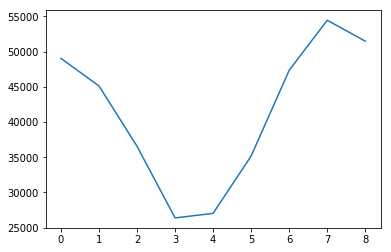

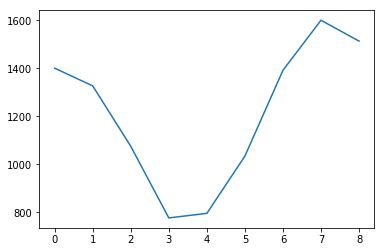

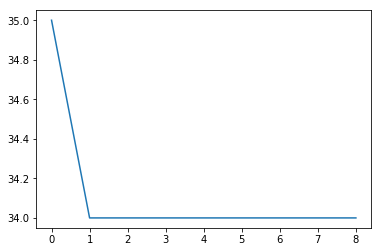

In [16]:
%matplotlib inline
plt.plot(parameters_order,totals)
plt.show()

plt.plot(parameters_order,np.divide(totals,data_totals))
plt.show()

plt.plot(parameters_order,data_totals)
plt.show()

In [17]:
results = multi_matches.finish(removeAmbiguous=False)
matches = extract_coincidences(results)

In [37]:
objs = []
for match in matches:
    if len(matches[match]) == 9:
        obj = matches[match]
        objs.append(obj)

In [38]:
len(objs)

7430

In [39]:

obj = objs[5000]
stamp_list = get_stamps(obj, directory, visit)

In [40]:
len(stamp_list)

9

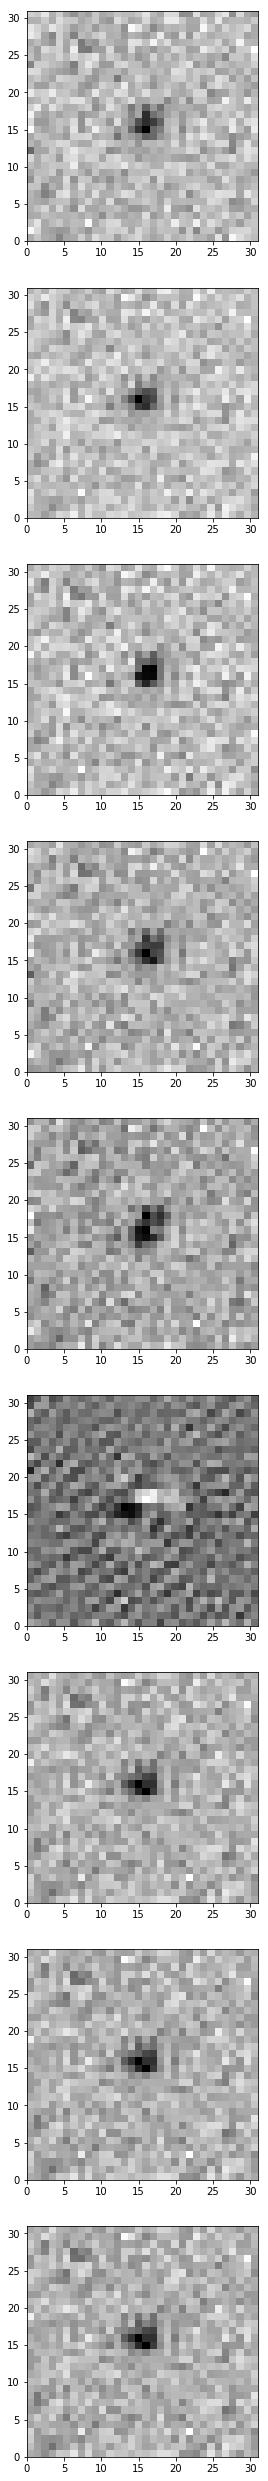

In [41]:
display_sources(stamp_list)

In [42]:
ccds = range(0,36)
parameters_order = range(50,525, 25)
directory = DATADIR+"deepDiffTests/CellSizes/deepDiffTest"
visit = 850586

totals, data_totals, multi_matches = extract_statistics_from_datatest(ccds, parameters_order, directory, visit)

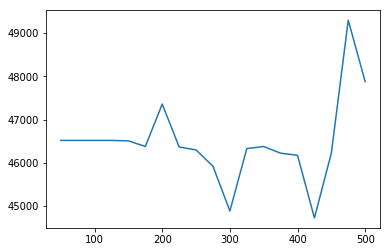

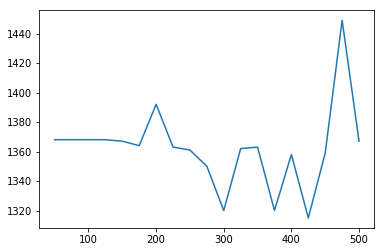

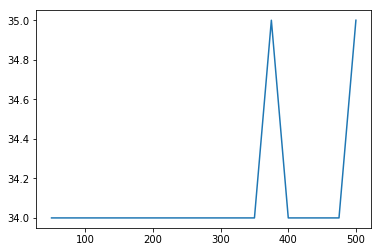

In [43]:
%matplotlib inline
plt.plot(parameters_order,totals)
plt.show()

plt.plot(parameters_order,np.divide(totals,data_totals))
plt.show()

plt.plot(parameters_order,data_totals)
plt.show()

In [44]:
results = multi_matches.finish(removeAmbiguous=False)
matches = extract_coincidences(results)

In [57]:
objs = []
for match in matches:
    if len(matches[match]) > 10:
        obj = matches[match]
        objs.append(obj)

In [58]:
len(objs)

47661

In [59]:

obj = objs[5000]
stamp_list = get_stamps(obj, directory, visit)

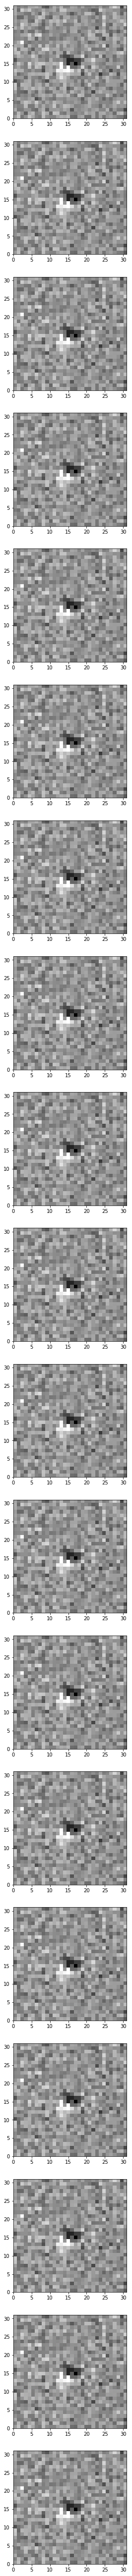

In [60]:
display_sources(stamp_list)

In [61]:
ccds = range(0,36)
parameters_order = range(3,9, 1)
directory = DATADIR+"deepDiffTests/DegGaussians/deepDiffTest"
visit = 850586

totals, data_totals, multi_matches = extract_statistics_from_datatest(ccds, parameters_order, directory, visit)

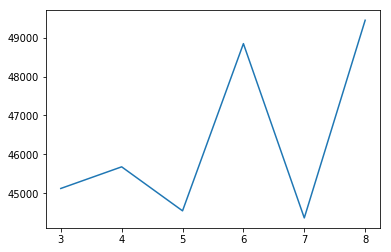

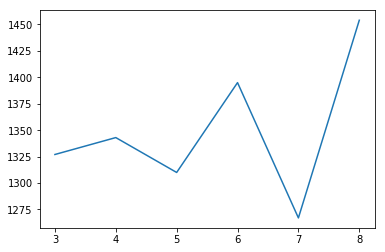

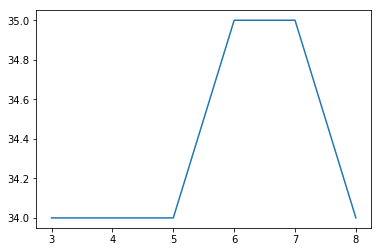

In [62]:
plt.plot(parameters_order,totals)
plt.show()

plt.plot(parameters_order,np.divide(totals,data_totals))
plt.show()

plt.plot(parameters_order,data_totals)
plt.show()

In [63]:
results = multi_matches.finish(removeAmbiguous=False)
matches = extract_coincidences(results)

In [66]:
objs = []
for match in matches:
    if len(matches[match]) == 6:
        obj = matches[match]
        objs.append(obj)

In [67]:
len(objs)

11477

In [78]:

obj = objs[6785]
stamp_list = get_stamps(obj, directory, visit)

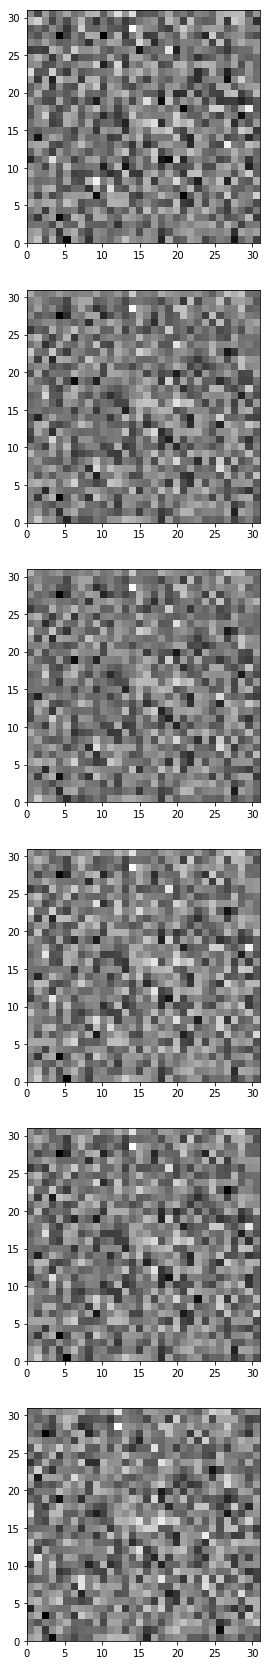

In [79]:
display_sources(stamp_list)

In [250]:
ccds = range(0,36)
parameters_order = range(0,9)
directory = DATADIR+"/deepDiffTests/SpatialKernelOrders/deepDiffTest"
visit = 850586

totals, data_totals, multi_matches, catalogs = extract_statistics_from_class_datatest(ccds, parameters_order, directory, visit)

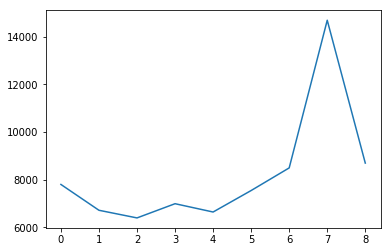

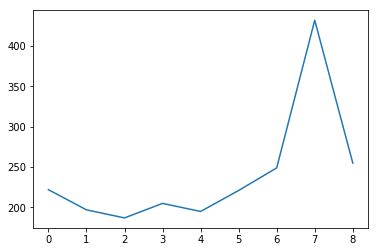

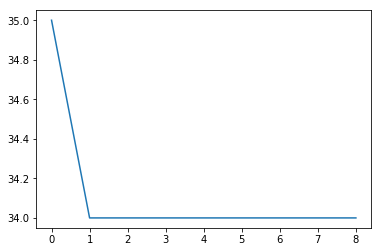

In [251]:
plt.plot(parameters_order,totals)
plt.show()

plt.plot(parameters_order,np.divide(totals,data_totals))
plt.show()

plt.plot(parameters_order,data_totals)
plt.show()

In [252]:

classification_dict = {0:"Dipole type I", 1: "Dipole type II", 3:"Fringe", 4: "Artifact", 5:"Negative", 6:"Positive", 7:"Point Positive"}
all_data = {}





for key in catalogs:
    data = initialize_data(classification_dict)
    visit_catalogs = catalogs[key]
    for catalog in visit_catalogs:
        for source in catalog:
            data[classification_dict[source["classification_dipole"]]] += 1
    all_data[key] = data

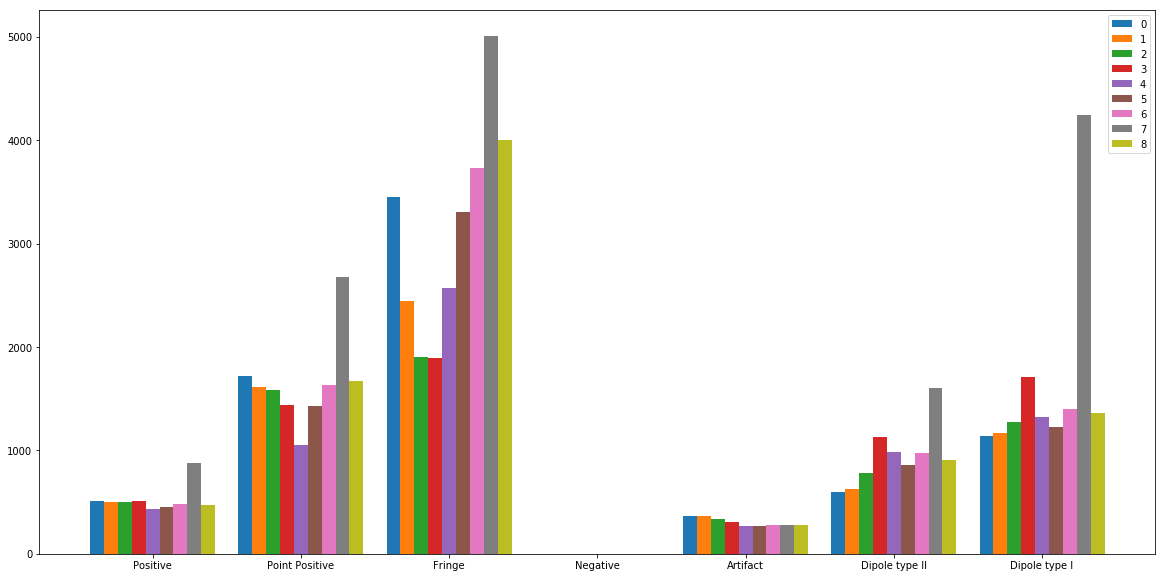

In [253]:
plt.figure(figsize=(20,10))

size = 0.75
mi_size = size/2
x = np.arange(len(classification_dict.keys()))
len_pars = len(all_data)
bar_lenght = size/(len_pars-1)



for i, key in enumerate(np.sort(all_data.keys())):
    p = plt.bar( x+(i*bar_lenght-mi_size) , all_data[key].values(), bar_lenght, label=key)

plt.xticks(x, all_data[key].keys())
plt.legend()
plt.show()

In [85]:
results = multi_matches.finish(removeAmbiguous=False)
matches = extract_coincidences(results)
objs = []


1430

In [95]:
for match in matches:
    if len(matches[match]) == 5:
        obj = matches[match]
        objs.append(obj)
        
len(objs)

4571

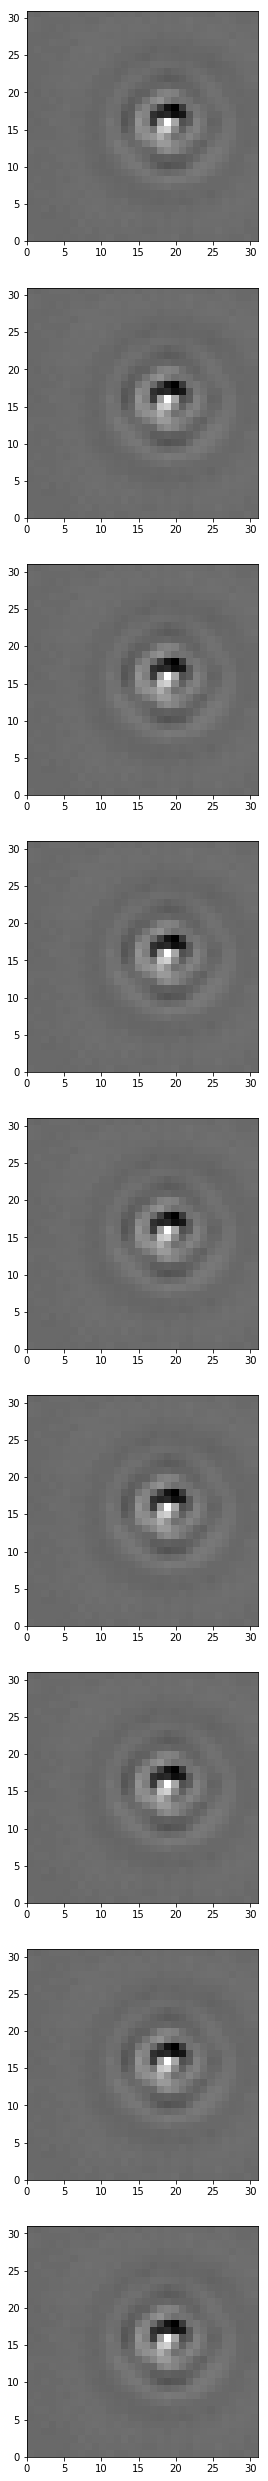

In [97]:
obj = objs[2500]
stamp_list = get_stamps(obj, directory, visit)
display_sources(stamp_list)

In [101]:
for point in obj:
    print point["parameter"]

0
1
2
3
4
5
6
7
8


In [230]:
ccds = range(0,36)
parameters_order = range(50,525, 25)
directory = DATADIR+"/deepDiffTests/CellSizes/deepDiffTest"
visit = 850586

totals, data_totals, multi_matches, catalogs = extract_statistics_from_class_datatest(ccds, parameters_order, directory, visit)

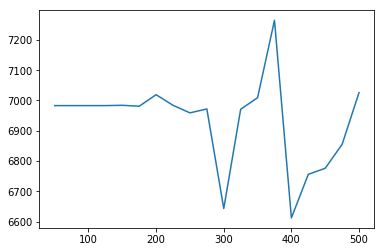

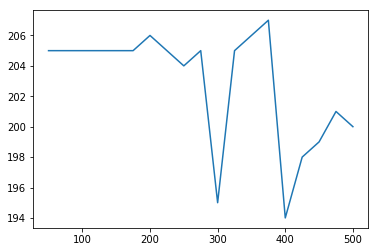

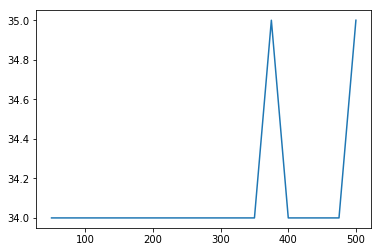

In [231]:
plt.plot(parameters_order,totals)
plt.show()

plt.plot(parameters_order,np.divide(totals,data_totals))
plt.show()

plt.plot(parameters_order,data_totals)
plt.show()

In [244]:

classification_dict = {0:"Dipole type I", 1: "Dipole type II", 3:"Fringe", 4: "Artifact", 5:"Negative", 6:"Positive", 7:"Point Positive"}
all_data = {}





for key in catalogs:
    data = initialize_data(classification_dict)
    visit_catalogs = catalogs[key]
    for catalog in visit_catalogs:
        for source in catalog:
            data[classification_dict[source["classification_dipole"]]] += 1
    all_data[key] = data

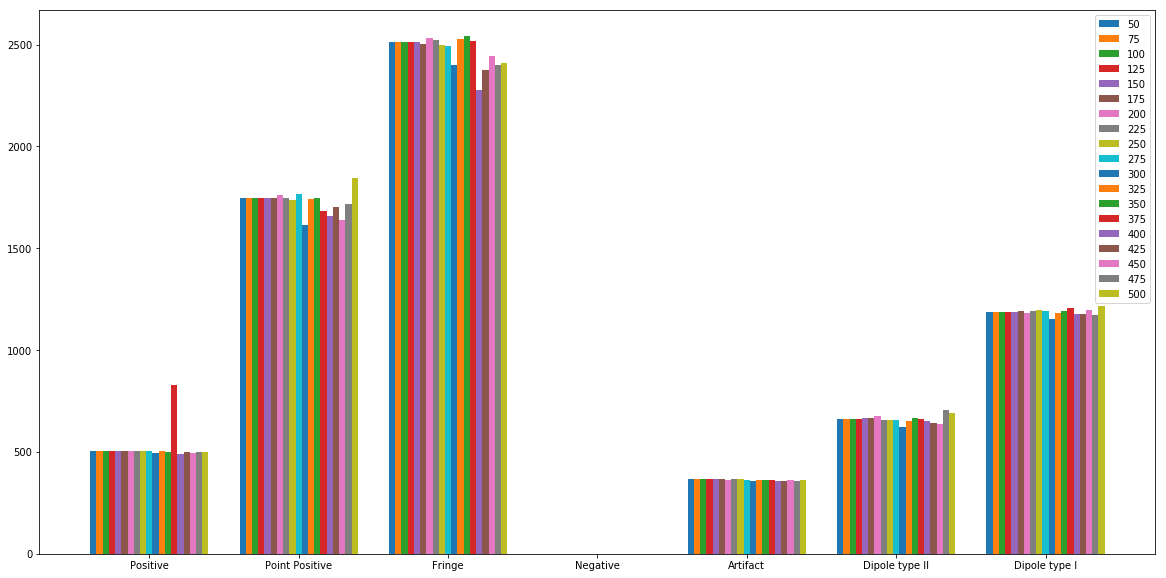

In [249]:
plt.figure(figsize=(20,10))

size = 0.75
mi_size = size/2
x = np.arange(len(classification_dict.keys()))
len_pars = len(all_data)
bar_lenght = size/(len_pars-1)



for i, key in enumerate(np.sort(all_data.keys())):
    p = plt.bar( x+(i*bar_lenght-mi_size) , all_data[key].values(), bar_lenght, label=key)

plt.xticks(x, all_data[key].keys())
plt.legend()
plt.show()

In [105]:
results = multi_matches.finish(removeAmbiguous=False)
matches = extract_coincidences(results)
objs = []


In [107]:
for match in matches:
    if len(matches[match]) > 10:
        obj = matches[match]
        objs.append(obj)
        
len(objs)

6980

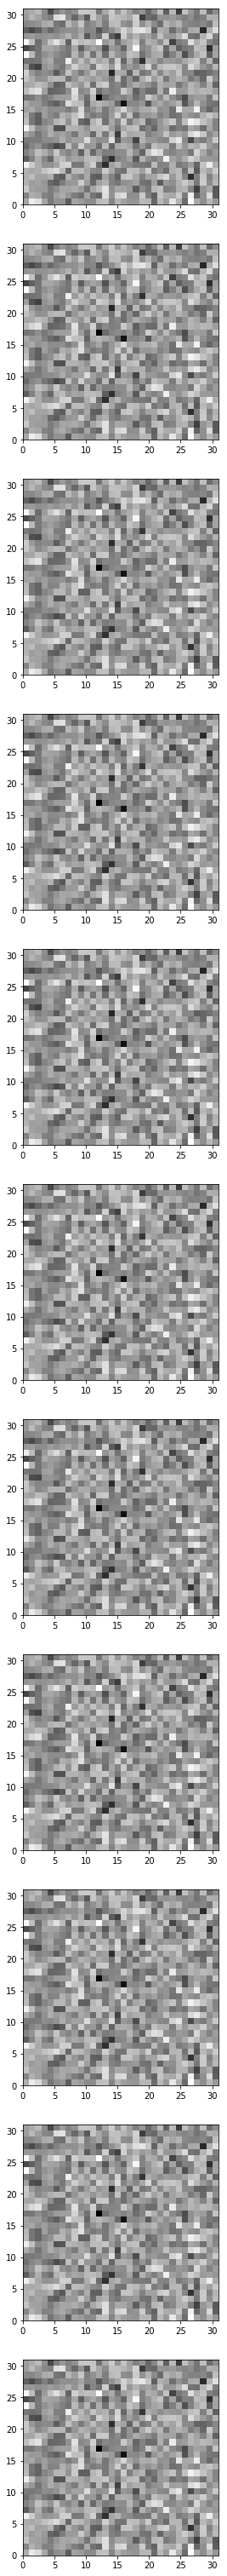

In [111]:
obj = objs[6976]
stamp_list = get_stamps(obj, directory, visit)
display_sources(stamp_list)

In [126]:
ccds = range(0,36)
parameters_order = range(3,9, 1)
directory = DATADIR+"deepDiffTests/DegGaussians/deepDiffTest"
visit = 850586

totals, data_totals, multi_matches, catalogs = extract_statistics_from_class_datatest(ccds, parameters_order, directory, visit)

In [162]:
def initialize_data(target_dict):
    input_dict = {}
    for key in target_dict:
        input_dict[target_dict[key]] = 0
    return input_dict

In [163]:
visit_catalogs = catalogs[3]
classification_dict = {0:"Dipole type I", 1: "Dipole type II", 3:"Fringe", 4: "Artifact", 5:"Negative", 6:"Positive", 7:"Point Positive"}
all_data = {}





for key in catalogs:
    data = initialize_data(classification_dict)
    visit_catalogs = catalogs[key]
    for catalog in visit_catalogs:
        for source in catalog:
            data[classification_dict[source["classification_dipole"]]] += 1
    all_data[key] = data

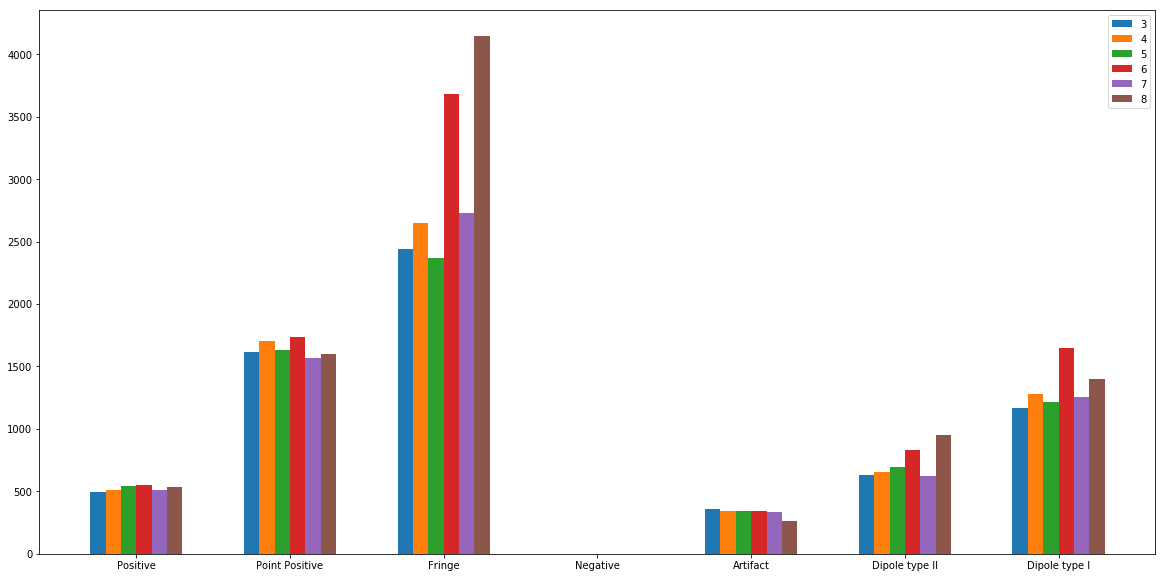

In [228]:
plt.figure(figsize=(20,10))

x = np.arange(len(classification_dict.keys()))
len_pars = len(all_data)
bar_lenght = 0.5/(len_pars-1)

for i, key in enumerate(all_data):
    
    p = plt.bar( x+(i*bar_lenght-0.25) , all_data[key].values(), bar_lenght, label=key)

plt.xticks(x, all_data[key].keys())
plt.legend()
plt.show()

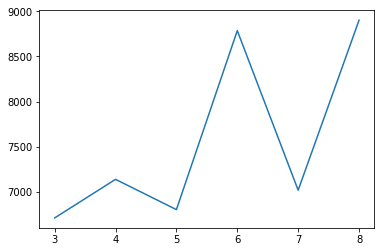

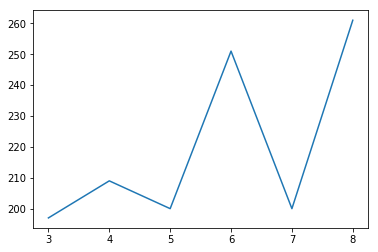

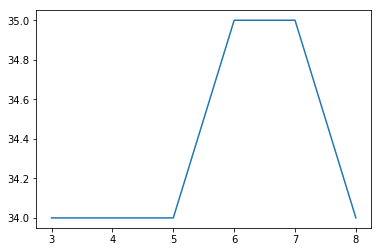

In [127]:
plt.plot(parameters_order,totals)
plt.show()

plt.plot(parameters_order,np.divide(totals,data_totals))
plt.show()

plt.plot(parameters_order,data_totals)
plt.show()

In [114]:
results = multi_matches.finish(removeAmbiguous=False)
matches = extract_coincidences(results)
objs = []


In [116]:
for match in matches:
    if len(matches[match]) == 6:
        obj = matches[match]
        objs.append(obj)
        
len(objs)

2972

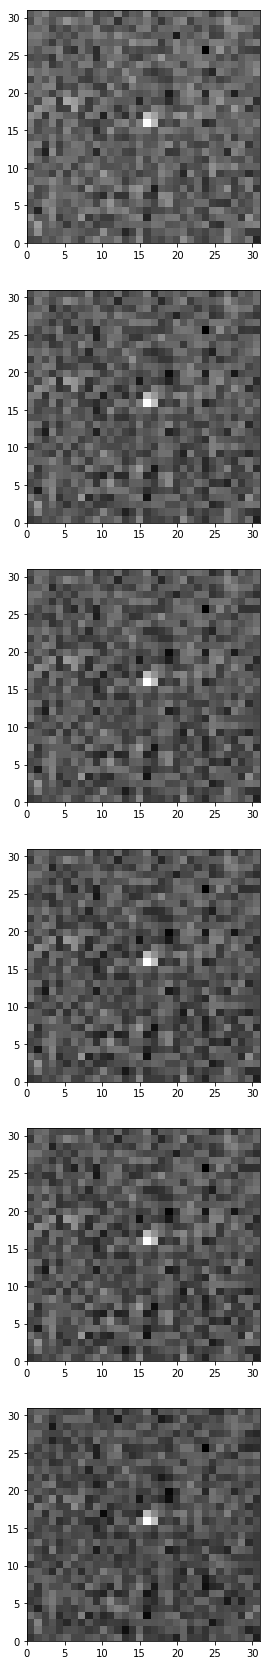

In [120]:
obj = objs[2000]
stamp_list = get_stamps(obj, directory, visit)
display_sources(stamp_list)